# Assignment 4 - diagnostic systems

- Student 1 - Luca Modica
- Student 2 - Hugo Manuel Alves Henriques E Silva

---

## Import libraries

In [218]:
# libraries for for drawing trees
%pip install graphviz pydotplus


Note: you may need to restart the kernel to use updated packages.


In [219]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import icecream as ic

sns.set_style('darkgrid')
%matplotlib inline

## Reading and analysing data

In [220]:
df = pd.read_pickle('wdbc.pkl')

In [221]:
df.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The following heatmap shows the correlation between the different features of the dataset. In this way, we have a first measure of the relationship and interaction between the different features.

In [222]:
data = df.drop(columns=['id'], axis=1)
corr_df = data.corr()
corr_df.head()

,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,symmetry_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
malignant,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_0,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_0,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_0,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_0,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738


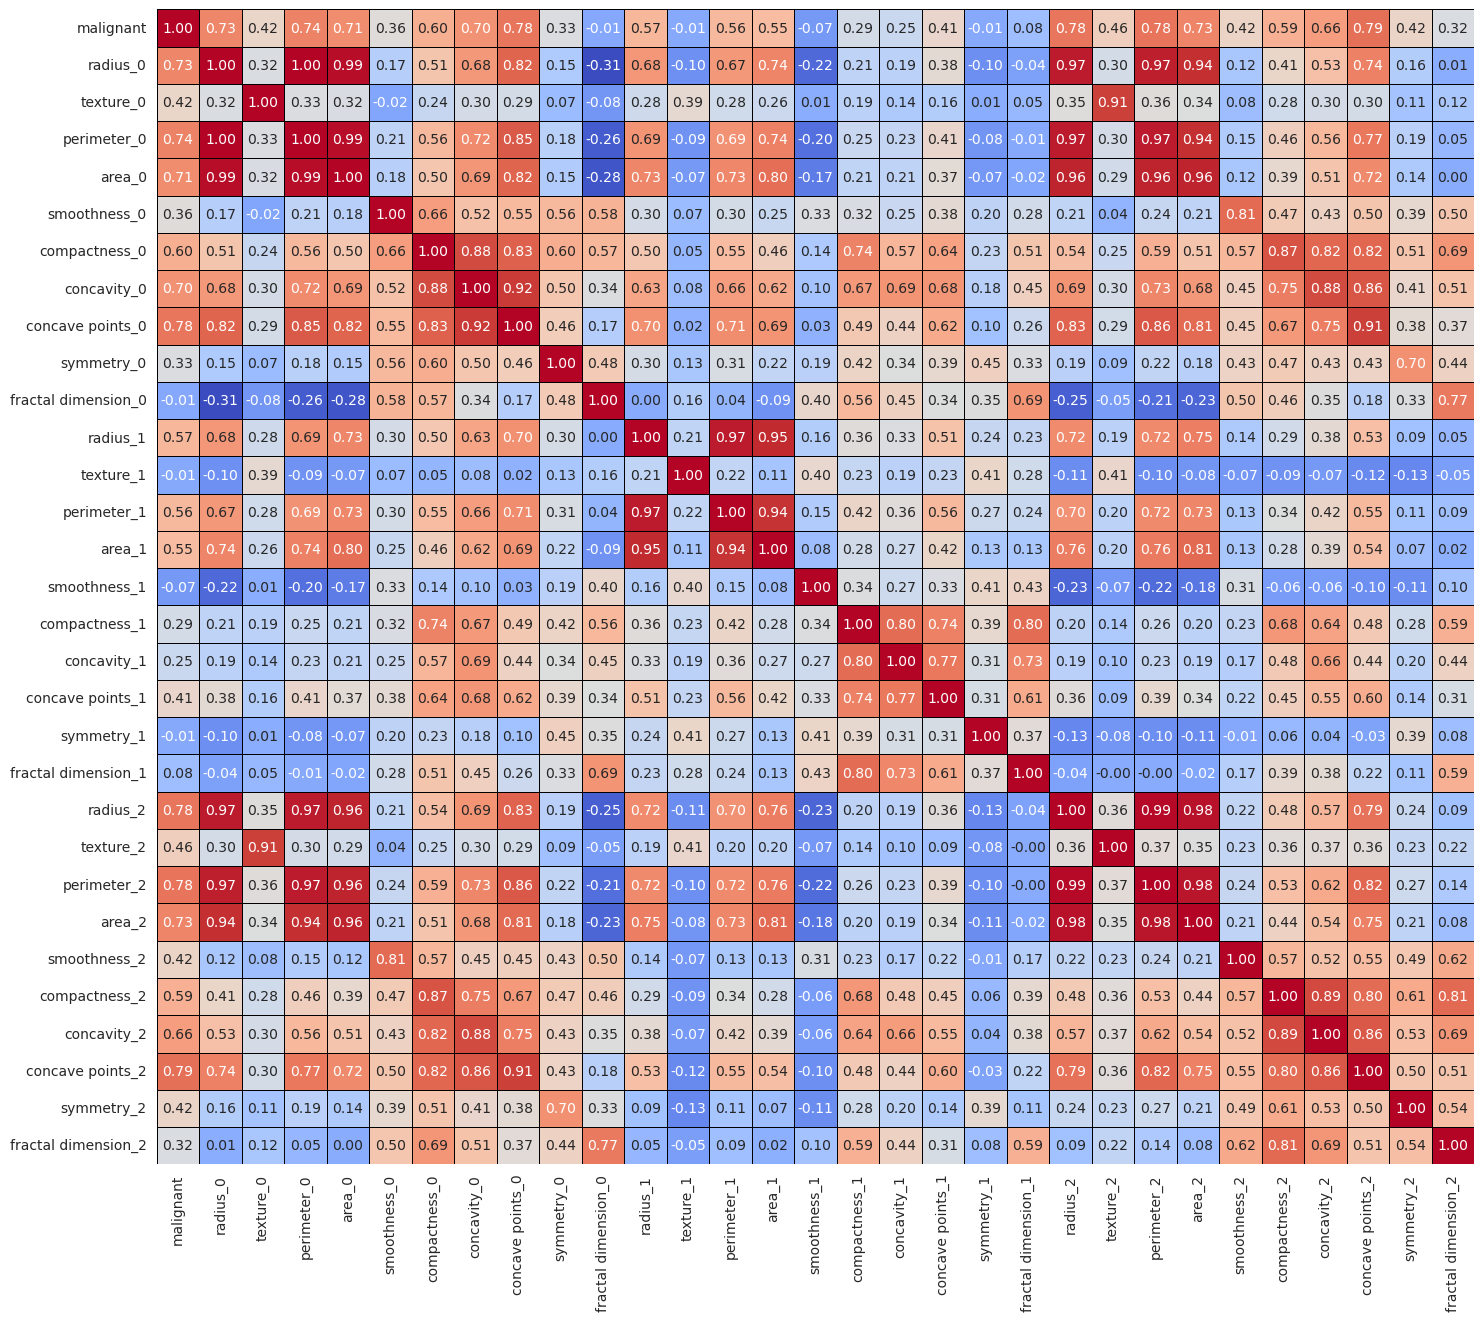

In [223]:
plt.figure(figsize=(17, 15))
sns.heatmap(data=corr_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, linecolor='black', cbar=False)
plt.show()

## Model implementation and evaluation

In [224]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

def top_n_feature_importance(n, clf, X_test, y_test):
    """The importance of the feature will be computed
    using permutation importance."""
    result = permutation_importance(
        clf, X_test, y_test, n_repeats=10, random_state=42)

    importances = result.importances_mean
    feature_names = clf.feature_names_in_
    features = sorted(zip(feature_names, importances),
                      key=lambda x: x[1], reverse=True)

    for feature_name, importance in features[:n]:
        print(f"Feature: {feature_name}, Importance: {importance}")
        

def plot_roc_curve(y_test, y_pred):

    fpr, tpr = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


### Model 1 - Rule Based Calssifier

1) The presence of signiﬁcantly larger cells is evidence for the uncontrolled growth that is indicative of malignant tumors.

This can be represented by `radius` and `area`.

    
2) The shape of benign cells usually shows only limited variance, whereas malignant cells can develop arbitrary structures that do not conform with the general pattern of their surroundings.

This can be represented by `smoothness`, `compactness`, `concativity`, and `concave points`.
   
3) The color of the cell nucleus should be identical for regular cells of the same type. Cancer cells often have signiﬁcantly larger and darker nuclei that are more densely packed with DNA.

   
4) Regular cells show similar texture. Malignant tumors, on the other hand, can range from smooth surfaces to ragged or lumpy textures for neighbouring cells.

This can be represented by `texture` and `smoothness`.
   
5) Finally, for healthy tissue, cell arrangement tends to be orderly, with regular distances between cells. Cancer cells can spread out or clutter almost arbitrarily.

This can be represented by `symmetry` and `fractal dimension`.




The best
single-plane classifier separated benign from
malignant points based on three nuclear feature
values for each case: mean texture, the worst area,
and the worst smoothness. 

In [225]:
class RuleBasedClassifier:
    def __init__(self):
        self.rules = []

    def add_rule(self, condition, label, else_label="Unknown"):
        self.rules.append((condition, label, else_label))
        return self

    def classify(self, X: pd.DataFrame):
        for condition, label, else_label in self.rules:
            return [label if condition(x) else else_label for _, x in X.iterrows()]


In [226]:
# cell size rule vars
cell_radius_mean = data['radius_0'].mean()
cell_radius_std = data['radius_1'].mean()
cell_radius_worst = data['radius_2'].mean()

cell_area_mean = data['area_0'].mean()
cell_area_std = data['area_1'].mean()
cell_area_worst = data['area_2'].mean()

# cell shape rule vars
cell_compactness_mean = data['compactness_0'].mean()
cell_compactness_std = data['compactness_1'].mean()
cell_compactness_worst = data['compactness_2'].mean()

cell_concavity_mean = data['concavity_0'].mean()
cell_concavity_std = data['concavity_1'].mean()
cell_concavity_worst = data['concavity_2'].mean()

cell_concave_points_mean = data['concave points_0'].mean()
cell_concave_points_std = data['concave points_1'].mean()
cell_concave_points_worst = data['concave points_2'].mean()

cell_smoothness_mean = data['smoothness_0'].mean()
cell_smoothness_std = data['smoothness_1'].mean()
cell_smoothness_worst = data['smoothness_2'].mean()

# cell arrangement rule vars
cell_symmetry_mean = data['symmetry_0'].mean()
cell_symmetry_std = data['symmetry_1'].mean()
cell_symmetry_worst = data['symmetry_2'].mean()

cell_fractal_dimension_mean = data['fractal dimension_0'].mean()
cell_fractal_dimension_std = data['fractal dimension_1'].mean()
cell_fractal_dimension_worst = data['fractal dimension_2'].mean()

#----------------------------------#

cell_texture_mean_1 = data[data['malignant'] == 1]['texture_0'].mean()
cell_texture_std_1 = data[data['malignant'] == 1]['texture_1'].mean()
cell_texture_worst_1 = data[data['malignant'] == 1]['texture_2'].mean()

cell_smoothness_mean_1 = data[data['malignant'] == 1]['smoothness_0'].mean()
cell_smoothness_std_1 = data[data['malignant'] == 1]['smoothness_1'].mean()
cell_smoothness_worst_1 = data[data['malignant'] == 1]['smoothness_2'].mean()

cell_symmetry_mean_1 = data[data['malignant'] == 1]['symmetry_0'].mean()
cell_symmetry_std_1 = data[data['malignant'] == 1]['symmetry_1'].mean()
cell_symmetry_worst_1 = data[data['malignant'] == 1]['symmetry_2'].mean()

cell_fractal_dimension_mean_1 = data[data['malignant']
                                     == 1]['fractal dimension_0'].mean()
cell_fractal_dimension_std_1 = data[data['malignant']
                                    == 1]['fractal dimension_1'].mean()
cell_fractal_dimension_worst_1 = data[data['malignant']
                                      == 1]['fractal dimension_2'].mean()


In [227]:
def abnormal_cell_size(x):
    return abs(x['radius_0'] - cell_radius_mean) > cell_radius_std and x['radius_2'] > cell_radius_worst and \
        abs(x['area_0'] -
            cell_area_mean) > cell_area_std and x['area_2'] > cell_area_worst


def abnormal_cell_shape(x):
    return abs(x['compactness_0'] - cell_compactness_mean) > cell_compactness_std and x['compactness_2'] > cell_compactness_worst and \
        abs(x['smoothness_0'] - cell_smoothness_mean) > cell_smoothness_std and x['smoothness_2'] > cell_smoothness_worst and \
        abs(x['concavity_0'] - cell_concavity_mean) > cell_concavity_std and x['concavity_2'] > cell_concavity_worst and \
        abs(x['concave points_0'] -
            cell_concave_points_mean) > cell_concave_points_std and x['concave points_2'] > cell_concave_points_worst


def abnormal_cell_texture(x):
    return abs(x['texture_0'] - cell_texture_mean_1) > cell_texture_std_1 and x['texture_2'] > cell_texture_worst_1 and \
        abs(x['smoothness_0'] -
            cell_smoothness_mean_1) > cell_smoothness_std_1 and x['smoothness_2'] > cell_smoothness_worst


def abnormal_cell_homogeneity(x):
    return abs(x['symmetry_0'] - cell_symmetry_mean_1) > cell_symmetry_std_1 and x['symmetry_2'] > cell_symmetry_worst_1 and \
        abs(x['fractal dimension_0'] -
            cell_fractal_dimension_mean_1) > cell_fractal_dimension_std_1 and x['fractal dimension_2'] > cell_fractal_dimension_worst_1


def rule(x):
    rule1 = abnormal_cell_size(x)
    rule2 = abnormal_cell_shape(x)
    rule3 = abnormal_cell_texture(x)
    rule4 = abnormal_cell_homogeneity(x)

    return rule1 or rule2 or rule3 or rule4

In [228]:
rule_clf = RuleBasedClassifier()
rule_clf.add_rule(rule, 1, 0)
y_pred = rule_clf.classify(data)
y_true = data['malignant']

In [229]:
print(confusion_matrix(y_true, y_pred))

[[343  14]
 [ 26 186]]


In [230]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       357
           1       0.93      0.88      0.90       212

    accuracy                           0.93       569
   macro avg       0.93      0.92      0.92       569
weighted avg       0.93      0.93      0.93       569



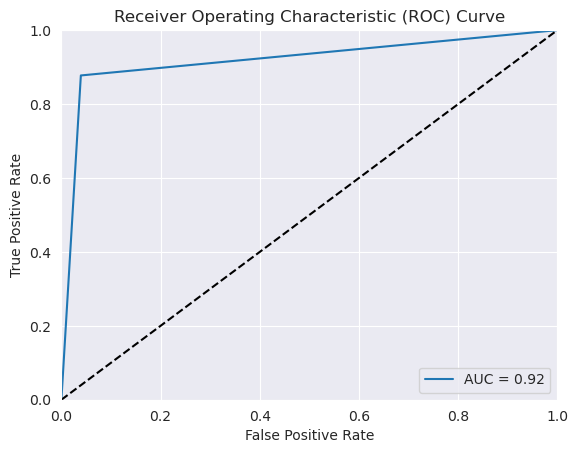

In [231]:
plot_roc_curve(y_true, y_pred)

### Model 2 - Random Forest

In [232]:
hyperparameters_rf = {
  "n_estimators": [50, 100, 200, 1000, 1500, 2000],
  "max_depth": [5, 10, 20, 50, 100, None],
  "min_samples_split": [2, 5, 10],
  "max_features": ['log2', 'sqrt']
}

In [233]:
# feature selection based on high correlation with the other features and the domain knowledge
# (in particular, it's based on the observation in the heatmap that the features are highly correlated 
# with each other, instead of which one are used in the rules above)

# features_to_drop = ['perimeter_0', 'perimeter_1', 'perimeter_2', 'concave points_0', 'concave points_1', 'concave points_2']
# X_selected = data.drop(columns=['malignant'] + features_to_drop)

X_selected = data.drop(columns=['malignant'])

In [234]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, data['malignant'], test_size=0.2, random_state=42)


In [235]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomizedSearchCV(RandomForestClassifier(random_state=42), hyperparameters_rf, n_iter=100, cv=5, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 50, 100, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 1000,
                                                         1500, 2000]},
                   random_state=42)

In [236]:
clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'max_features': 'log2',
 'max_depth': None}

### Evaluation

In [237]:
y_pred_rf = clf.predict(X_test)

In [238]:
print(confusion_matrix(y_test, y_pred_rf))

[[70  1]
 [ 2 41]]


In [239]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



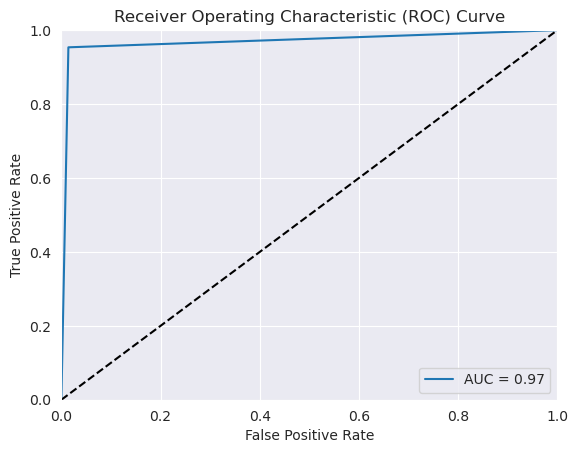

In [240]:
plot_roc_curve(y_test, y_pred_rf)

### Interpretation

In [263]:
rf = clf.best_estimator_
top_n_feature_importance(5, rf, X_test=X_test, y_test=y_test)

Feature: concave points_0, Importance: 0.009649122807017574
Feature: concavity_0, Importance: 0.0052631578947368585
Feature: radius_2, Importance: 0.0052631578947368585
Feature: perimeter_2, Importance: 0.0052631578947368585
Feature: perimeter_0, Importance: 0.004385964912280715


<Figure size 1400x1000 with 0 Axes>

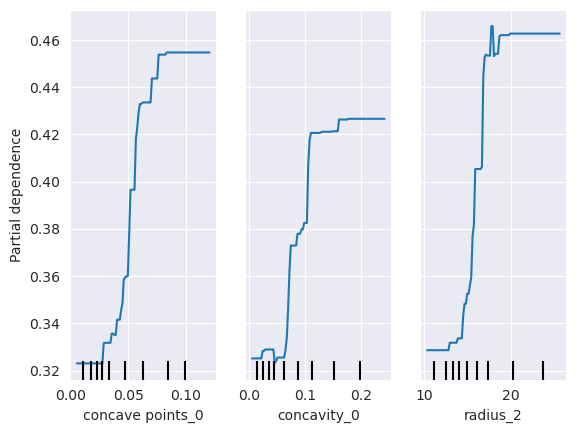

In [261]:
from sklearn.inspection import PartialDependenceDisplay

# relationship between the 3 most important features for the model and
# how much they contribute to the prediction probability
plt.figure(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(
    rf, X_train, features=['concave points_0', 'concavity_0', 'radius_2'])
plt.show()

Advantages of the Partial Dependence Plot:

- It shows how a feature affects the model's predictions
- It shows if the relationship between the feature and the response is linear, monotonic, or more complex
- show a causal relationship between the feature and the response

To try to explain the random forest even more, we will use LIIME to explain the some predictions examples of the model.

In [243]:
import lime
import lime.lime_tabular


def predict_fn_rf(x): return rf.predict_proba(x).astype(float)

X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(
    X, feature_names=X_train.columns, class_names=['Benign', 'Malignant'])


example and explanation of a bengin instance using LIME

In [244]:
print('benign' if y_test.iloc[0] == 0 else 'malignant')
X_test.iloc[[0]]

benign


,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,symmetry_0,fractal dimension_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
204,12.47,18.6,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.0875


/home/lucamodica/mambaforge/envs/design-ai/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


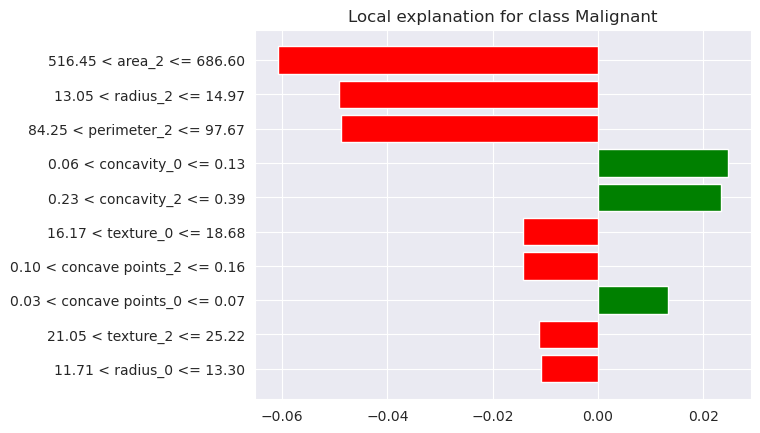

In [245]:
choosen_instance = X_test.iloc[[0]].values[0]
exp = explainer.explain_instance(
    choosen_instance, predict_fn_rf, num_features=10)

exp.as_pyplot_figure()
plt.show()

In [246]:
X_test.iloc[[0]]


,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,symmetry_0,fractal dimension_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
204,12.47,18.6,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.0875


In [247]:
# print out the top three features that are contributing to the prediction:
for i in range(3):
    print(f"{exp.as_list()[i][0]}: {exp.as_list()[i][1]:.2f}")


516.45 < area_2 <= 686.60: -0.06
13.05 < radius_2 <= 14.97: -0.05
84.25 < perimeter_2 <= 97.67: -0.05


example of a malignant instance.

In [248]:
print('benign' if y_test.iloc[70] == 0 else 'malignant')
X_test.iloc[[70]]


malignant


,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,symmetry_0,fractal dimension_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
196,13.77,22.29,90.63,588.9,0.12,0.1267,0.1385,0.06526,0.1834,0.06877,...,16.39,34.01,111.6,806.9,0.1737,0.3122,0.3809,0.1673,0.308,0.09333


/home/lucamodica/mambaforge/envs/design-ai/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


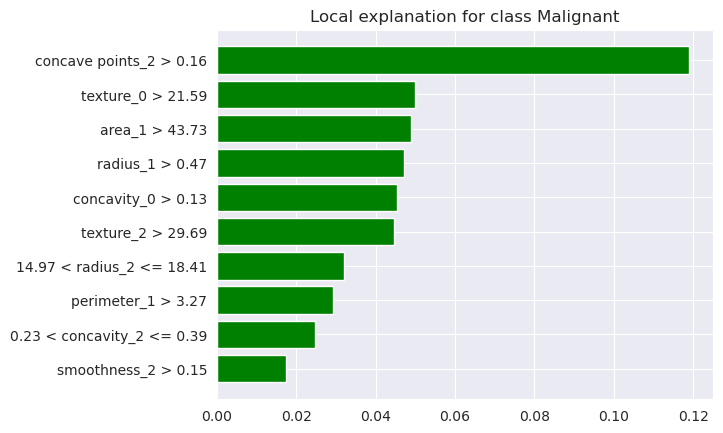

In [249]:
choosen_instance = X_test.iloc[[70]].values[0]
exp = explainer.explain_instance(
    choosen_instance, predict_fn_rf, num_features=10)

exp.as_pyplot_figure()
plt.show()

### Model 3 - classifier with interpretability and classification performance tradeoff

In [250]:
from sklearn.tree import DecisionTreeClassifier

In [251]:
hyperparams_dt = {
  "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
  "criterion": ["gini", "entropy"],
  "min_samples_split": [2, 5, 10],
  "max_features": ['log2', 'sqrt', None]
}

In [252]:
clf3 = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), hyperparams_dt, n_iter=100, cv=5, random_state=42, n_jobs=-1)
clf3.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42)

In [253]:
clf3.best_params_

{'min_samples_split': 10,
 'max_features': None,
 'max_depth': 70,
 'criterion': 'entropy'}

### Evaluation

In [254]:
y_pred_dt = clf3.predict(X_test)

In [255]:
print(confusion_matrix(y_test, y_pred_rf))

[[70  1]
 [ 2 41]]


In [256]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        71
           1       0.97      0.88      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



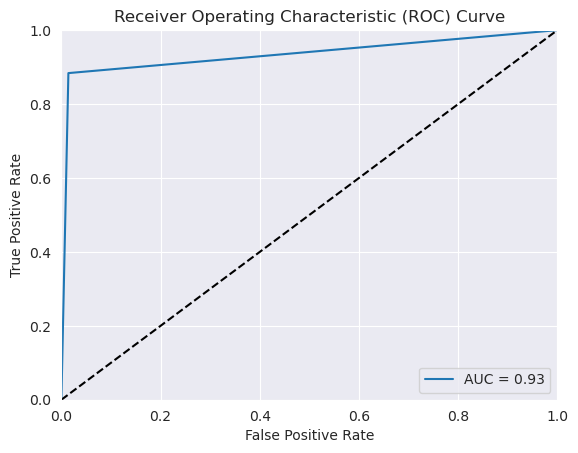

In [257]:
plot_roc_curve(y_test, y_pred_dt)

### Interpretation

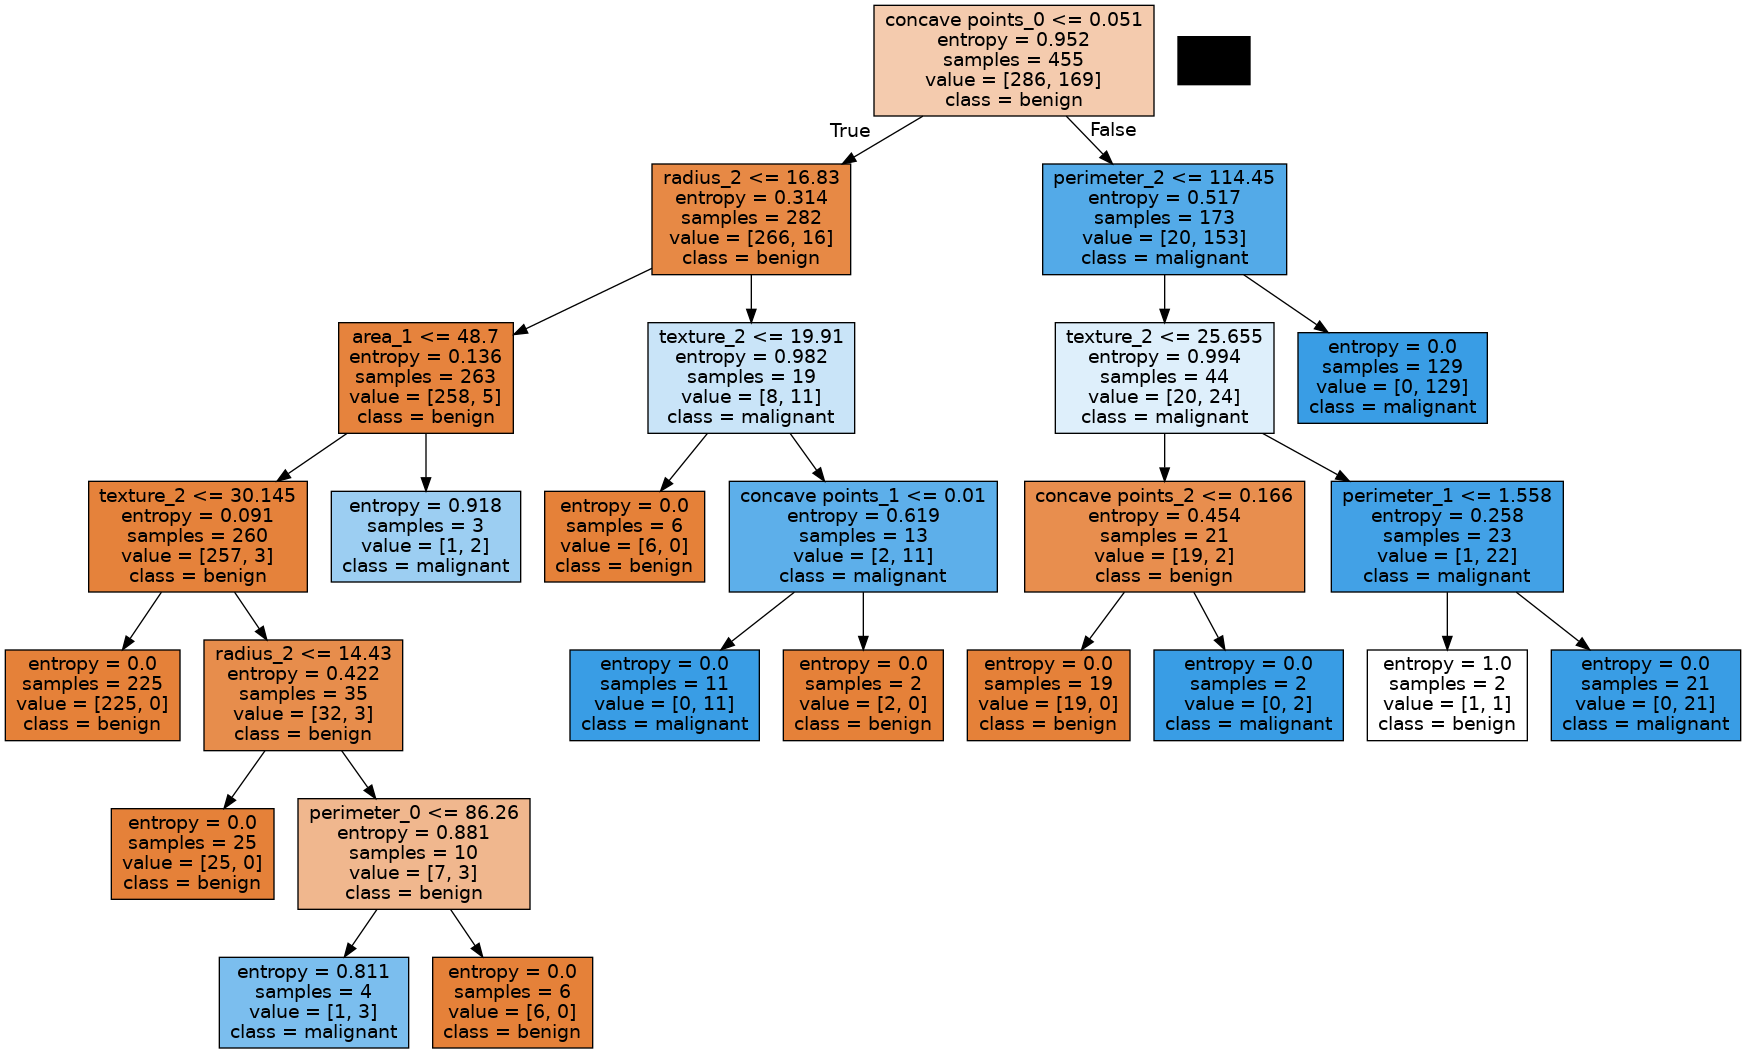

In [258]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dt = clf3.best_estimator_

dot_data = export_graphviz(
    dt, out_file=None, feature_names=dt.feature_names_in_, class_names=["benign", "malignant"], filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)

image = Image(graph.create_png())
image

In [262]:
top_n_feature_importance(5, dt, X_test=X_test, y_test=y_test)

Feature: concave points_0, Importance: 0.21578947368421045
Feature: area_1, Importance: 0.1403508771929824
Feature: radius_2, Importance: 0.12456140350877191
Feature: perimeter_2, Importance: 0.02368421052631574
Feature: texture_2, Importance: 0.019298245614035026
